<table align="center">
   <td align="center"><a target="_blank" href="https://colab.research.google.com/github/umbcdata602/fall2020/blob/master/lab_kernel_pca.ipynb">
<img src="http://introtodeeplearning.com/images/colab/colab.png?v2.0"  style="padding-bottom:5px;" />Run in Google Colab</a></td>
</table>

# Lab: Kernel PCA

"To understand the utility of kernel PCA, particularly for clustering, observe that, while N points cannot, in general, be linearly separated in $d < N$ dimensions, they can almost always be linearly separated in $ d >= N $ dimensions." (Ref: wikipedia article)

### References:

* Raschka's [ch05.ipynb](https://github.com/rasbt/python-machine-learning-book-3rd-edition/blob/master/ch05/ch05.ipynb)
* The Wikipedia topic on [Kernel PCA](https://careers.fanniemae.com/main/jobs/59040?lang=en-us) is a good supplement to the book.
* Likewise, for the [Centering matrix](https://en.wikipedia.org/wiki/Centering_matrix)

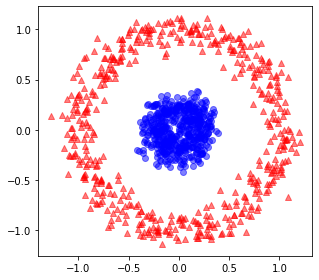

In [ ]:
# Cell 42 from Raschka
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

X, y = make_circles(n_samples=1000, random_state=123, noise=0.1, factor=0.2)

plt.scatter(X[y == 0, 0], X[y == 0, 1], color='red', marker='^', alpha=0.5)
plt.scatter(X[y == 1, 0], X[y == 1, 1], color='blue', marker='o', alpha=0.5)

plt.tight_layout()
plt.gca().set_aspect('equal');

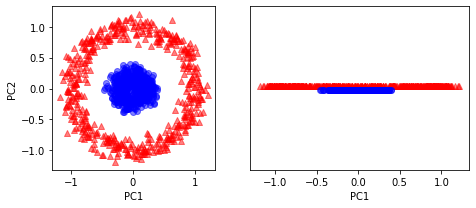

In [ ]:
# Cell 43
from sklearn.decomposition import PCA

scikit_pca = PCA(n_components=2)
X_spca = scikit_pca.fit_transform(X)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7, 3))

ax[0].scatter(X_spca[y == 0, 0], X_spca[y == 0, 1],
              color='red', marker='^', alpha=0.5)
ax[0].scatter(X_spca[y == 1, 0], X_spca[y == 1, 1],
              color='blue', marker='o', alpha=0.5)

ax[1].scatter(X_spca[y == 0, 0], np.zeros((500, 1)) + 0.02,
              color='red', marker='^', alpha=0.5)
ax[1].scatter(X_spca[y == 1, 0], np.zeros((500, 1)) - 0.02,
              color='blue', marker='o', alpha=0.5)

ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')
ax[1].set_ylim([-1, 1])
ax[1].set_yticks([])
ax[1].set_xlabel('PC1')

ax[0].set_aspect('equal')
plt.tight_layout();

# EXERCISE

Demonstrate how you can separate features by adding a new feature that depends exponentially on the squared distance from the origin:

`r = np.exp(-(X ** 2).sum(1))`

and visualize the data with a 3-D plot.



In [ ]:
import numpy as np

r = np.exp(-(X ** 2).sum(1))

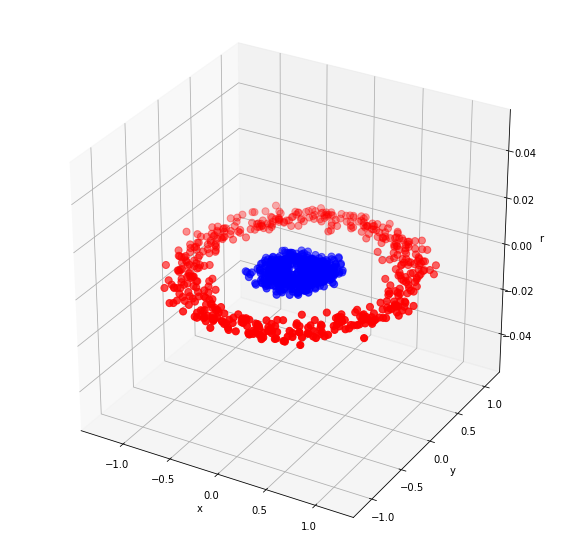

In [ ]:
from matplotlib.colors import ListedColormap

colors = ('red', 'blue')
cmap = ListedColormap(colors[:len(np.unique(y))])

fig = plt.figure(figsize=(10,10))
ax = plt.subplot(projection='3d')
ax.scatter3D(X[:, 0], X[:, 1], 0, c=y, s=50, cmap=cmap)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('r')
plt.show()

# Kernel PCA

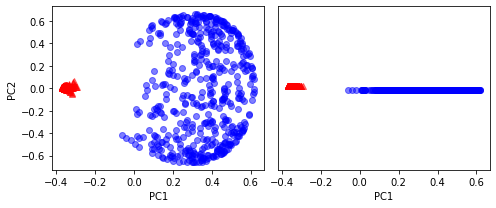

In [ ]:
from sklearn.decomposition import KernelPCA

# Scikit-learn implementation of Kernel PCA
kpca = KernelPCA(kernel="rbf", fit_inverse_transform=True, gamma=10)
X_kpca = kpca.fit_transform(X)

# Alternatively, you can use Raschka's implementation of the RBF kernel
#X_kpca = rbf_kernel_pca(X, gamma=10, n_components=2)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7, 3))
ax[0].scatter(X_kpca[y == 0, 0], X_kpca[y == 0, 1],
              color='red', marker='^', alpha=0.5)
ax[0].scatter(X_kpca[y == 1, 0], X_kpca[y == 1, 1],
              color='blue', marker='o', alpha=0.5)

ax[1].scatter(X_kpca[y == 0, 0], np.zeros((500, 1)) + 0.02,
              color='red', marker='^', alpha=0.5)
ax[1].scatter(X_kpca[y == 1, 0], np.zeros((500, 1)) - 0.02,
              color='blue', marker='o', alpha=0.5)

ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')
ax[1].set_ylim([-1, 1])
ax[1].set_yticks([])
ax[1].set_xlabel('PC1')

plt.tight_layout()
plt.show()

# Kernel PCA Algorithm

1. Compute the the N-by-N Kernel matrix $K(x_i, x_j)$.  
    * $x_i$ and $x_j$ are feature values associated with samples $i$ and $j$
    * $N$ is the number of samples
2. Center the matrix $K$ (both rows and columns).
3. Collect the top $k$ eigenvectors of $K$, based on their eigenvalues.

The eigenvectors of $K$ represent the reduced-dimension dataset after having been projected onto the eigenvectors of the higher-dimensional space.

In [ ]:
# Raschka's cell 32 -- RBF Kernel PCA
from scipy.spatial.distance import pdist, squareform
from scipy.linalg import eigh
import numpy as np
from numpy import exp

def rbf_kernel_pca(X, gamma, n_components):
    """
    RBF kernel PCA implementation.

    Parameters
    ------------
    X: {NumPy ndarray}, shape = [n_examples, n_features]
        
    gamma: float
      Tuning parameter of the RBF kernel
        
    n_components: int
      Number of principal components to return

    Returns
    ------------
     X_pc: {NumPy ndarray}, shape = [n_examples, k_features]
       Projected dataset   

    """
    # Calculate pairwise squared Euclidean distances
    # in the MxN dimensional dataset.
    sq_dists = pdist(X, 'sqeuclidean')

    print(sq_dists.shape)

    # Convert pairwise distances into a square matrix.
    mat_sq_dists = squareform(sq_dists)

    # Compute the symmetric kernel matrix.
    K = exp(-gamma * mat_sq_dists)

    # Center the kernel matrix.
    N = K.shape[0]
    one_n = np.ones((N, N)) / N
    K = K - one_n.dot(K) - K.dot(one_n) + one_n.dot(K).dot(one_n)

    # Obtaining eigenpairs from the centered kernel matrix
    # scipy.linalg.eigh returns them in ascending order
    eigvals, eigvecs = eigh(K)
    eigvals, eigvecs = eigvals[::-1], eigvecs[:, ::-1]

    # Collect the top k eigenvectors (projected examples)
    X_pc = np.column_stack([eigvecs[:, i]
                            for i in range(n_components)])

    return X_pc